### Ingest

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    cross_val_score,
    cross_val_predict,
    train_test_split,
    GridSearchCV
)

from sklearn.metrics import (
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from ipywidgets import interact, widgets

import pickle

In [2]:
# This wrangle function contains all the transformations done in the EDA section

def wrangle():
    """
    Returns X_train, y_train, X_test, y_test
    """
    df = pd.read_csv("dataset/archive/heart.csv")
    # Train test split
    df = df.drop_duplicates(keep='first')
    # split into train and test set
    train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['target'])
    
    # split into feature and label
    target_col = 'target'
    X_train  = train.drop(columns=['target'])
    y_train = train['target']
    X_test  = test.drop(columns=['target'])
    y_test = test['target']
    
    return X_train, y_train, X_test, y_test

In [3]:
# Apply the wrangle function and get the train and test data
X_train, y_train, X_test, y_test = wrangle()

In [4]:
X_train.shape, y_train.shape

((241, 13), (241,))

In [5]:
X_test.shape, y_test.shape

((61, 13), (61,))

### Preprocessing

In [6]:
# colums whose unique values are greater than or equal 3 --- referred to numeric columns
num_cols = [col for col in X_train.columns if X_train[col].nunique() >= 3]
# columns whose unique values are < 3 --- referred to as categorical columns
cat_cols = [col for col in X_train.columns if X_train[col].nunique() < 3]

In [7]:
print(num_cols)

['age', 'cp', 'trestbps', 'chol', 'restecg', 'thalach', 'oldpeak', 'slope', 'ca', 'thal']


In [8]:
print(cat_cols)

['sex', 'fbs', 'exang']


In [9]:
# one hot encoding pipeline for categorical columns
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(sparse_output=False)),
])

# Standard scaling for numerical columns
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

In [10]:
# Combine the pipelines with column transformer
preprocessing = ColumnTransformer(
    [
        ('num', num_pipeline, num_cols),
        ('cats', cat_pipeline, cat_cols)
    ]
)

In [11]:
# Test the preprocessing pipeline
X_train_transformed = preprocessing.fit_transform(X_train)

In [12]:
X_train_transformed[0]

array([ 0.28906186, -0.93569147, -0.19208565,  1.22278352, -1.04199213,
        0.40512154, -0.88967624,  0.96461102,  0.26403574, -0.5751421 ,
        1.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ])

In [13]:
preprocessing.get_feature_names_out()

array(['num__age', 'num__cp', 'num__trestbps', 'num__chol',
       'num__restecg', 'num__thalach', 'num__oldpeak', 'num__slope',
       'num__ca', 'num__thal', 'cats__sex_0', 'cats__sex_1',
       'cats__fbs_0', 'cats__fbs_1', 'cats__exang_0', 'cats__exang_1'],
      dtype=object)

In [14]:
print(f"The data was {X_train.shape} before transformation and {X_train_transformed.shape} after transformation")

The data was (241, 13) before transformation and (241, 16) after transformation


## Modelling

+ Logistic regression
+ Random Forest
+ Catboost

### Logistic regression

In [15]:
# Logistic regression pipeline
lr_pipeline = Pipeline([
    ('prep', preprocessing),
    ('logreg', LogisticRegression(random_state=42))
])

Note. There is no validation set so we use cross validation

In [16]:
# Cross validation accuracies
lr_cv_accs = cross_val_score(lr_pipeline, X_train, y_train, cv=5, n_jobs=-1)
lr_cv_accs

array([0.79591837, 0.77083333, 0.8125    , 0.875     , 0.89583333])

In [17]:
# Get the description of the cross validation
lr_desc = pd.Series(lr_cv_accs).describe()
lr_desc

count    5.000000
mean     0.830017
std      0.053215
min      0.770833
25%      0.795918
50%      0.812500
75%      0.875000
max      0.895833
dtype: float64

+ mean accuracy = 0.83
+ The accuracy ranges between 0.77 and 0.9

### RandomForest

In [18]:
rfc_pipeline = Pipeline([
    ('prep', preprocessing),
    ('rfc', RandomForestClassifier())
])

In [19]:
%time rfc_cv_accs = cross_val_score(rfc_pipeline, X_train, y_train, cv=5, n_jobs=-1)
rfc_cv_accs

CPU times: user 22.1 ms, sys: 535 µs, total: 22.6 ms
Wall time: 687 ms


array([0.75510204, 0.8125    , 0.77083333, 0.89583333, 0.89583333])

In [20]:
rfc_desc = pd.Series(rfc_cv_accs).describe()
rfc_desc

count    5.000000
mean     0.826020
std      0.067092
min      0.755102
25%      0.770833
50%      0.812500
75%      0.895833
max      0.895833
dtype: float64

+ Mean accuracy = 0.81
+ The accuracy ranges between 0.75 and 0.89

### catboost

In [21]:
cat_pipeline = Pipeline([
    ('prep', preprocessing),
    ('cat', CatBoostClassifier(verbose=0))
])

In [22]:
%time cat_cv_accs = cross_val_score(cat_pipeline, X_train, y_train, cv=5, n_jobs=-1)
cat_cv_accs

CPU times: user 38 ms, sys: 8.4 ms, total: 46.4 ms
Wall time: 6.19 s


array([0.75510204, 0.8125    , 0.83333333, 0.875     , 0.85416667])

In [23]:
cat_desc = pd.Series(cat_cv_accs).describe()
cat_desc

count    5.000000
mean     0.826020
std      0.045981
min      0.755102
25%      0.812500
50%      0.833333
75%      0.854167
max      0.875000
dtype: float64

In [24]:
pd.DataFrame({
    'log_reg': lr_desc,
    'random_forest': rfc_desc,
    'cat': cat_desc
})

,log_reg,random_forest,cat
count,5.000000,5.000000,5.000000
mean,0.830017,0.826020,0.826020
std,0.053215,0.067092,0.045981
min,0.770833,0.755102,0.755102
25%,0.795918,0.770833,0.812500
50%,0.812500,0.812500,0.833333
75%,0.875000,0.895833,0.854167
max,0.895833,0.895833,0.875000


+ Tune logistic regression
+ Tune catboost

## Hyperparameter tuning

### Fine tune Logistic regression

In [25]:
lr_grid_pipeline = Pipeline([
    ('prep', preprocessing),
    ('logreg', LogisticRegression(solver='saga', max_iter=500, random_state=42, n_jobs=-1))
])

In [26]:
# # Get the list of parameters that are available for tuning
# list(lr_grid_pipeline.get_params().keys())

In [27]:
lr_param_grid = [{
    'logreg__penalty': ['elasticnet'],
    'logreg__l1_ratio': [0.0, 0.2, 0.4, 0.6, 0.8, 1],
    'logreg__C': [0.2, 0.4, 0.6, 0.8, 1]
}]

In [28]:
lr_grid_search = GridSearchCV(
    lr_grid_pipeline, 
    lr_param_grid, cv=5,
    scoring='accuracy'
)

In [29]:
%time lr_grid_search.fit(X_train, y_train)

CPU times: user 3.97 s, sys: 182 ms, total: 4.15 s
Wall time: 4.77 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'cp',
                                                                          'trestbps',
                                                                          'chol',
                                                                          'restecg',
                                                                          'thalach',
                                                                          'oldpeak',
                                                                          'slope',
                                                                          'ca',
                                                                          'thal']),
                                                                        ('cats',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(sparse_output=False))]),
                                                                         ['sex',
                                                                          'fbs',
                                                                          'exang'])])),
                                       ('logreg',
                                        LogisticRegression(max_iter=500,
                                                           n_jobs=-1,
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid=[{'logreg__C': [0.2, 0.4, 0.6, 0.8, 1],
                          'logreg__l1_ratio': [0.0, 0.2, 0.4, 0.6, 0.8, 1],
                          'logreg__penalty': ['elasticnet']}],
             scoring='accuracy')

In [30]:
# Best parameters
lr_grid_search.best_params_

{'logreg__C': 0.2, 'logreg__l1_ratio': 0.6, 'logreg__penalty': 'elasticnet'}

In [31]:
# The best score
lr_grid_search.best_score_

0.842517006802721

In [32]:
lr_cv_res = pd.DataFrame(lr_grid_search.cv_results_)
lr_cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
# lr_cv_res.head()

In [33]:
logistic_results = lr_cv_res.set_index("rank_test_score").iloc[:, [0, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14]]
logistic_results.head()

,mean_fit_time,param_logreg__C,param_logreg__l1_ratio,param_logreg__penalty,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,
1,0.020580,0.2,0.6,elasticnet,0.795918,0.812500,0.833333,0.875000,0.895833,0.842517,0.037562
2,0.021576,0.2,0.4,elasticnet,0.795918,0.812500,0.812500,0.875000,0.895833,0.838350,0.039457
2,0.029526,0.2,0.8,elasticnet,0.795918,0.812500,0.833333,0.854167,0.895833,0.838350,0.034780
4,0.023296,0.2,0.0,elasticnet,0.795918,0.791667,0.812500,0.875000,0.895833,0.834184,0.042916
4,0.027131,0.8,0.2,elasticnet,0.795918,0.791667,0.812500,0.875000,0.895833,0.834184,0.042916


one point above, when trained mormally. The standard deviation is also reduced

In [34]:
# # Get the f1 socre
# print(classification_report(lr_grid_search, X_train, y_train))

### Fine tune catboost

In [35]:
cat_grid_pipeline = Pipeline([
    ('prep', preprocessing),
    ('cat', CatBoostClassifier(verbose=0))
])

In [36]:
# # Get the list of parameters that are available for tuning
# list(cat_grid_pipeline.get_params().keys())

In [37]:
cat_param_grid = [{
    'cat__learning_rate': [None, 0.02, 0.03],
    "cat__depth": [None, 6, 10],
    "cat__l2_leaf_reg": [None, 2, 3]
}]

In [38]:
cat_grid_search = GridSearchCV(
    cat_grid_pipeline, 
    cat_param_grid, cv=5,
    scoring='accuracy'
)

In [39]:
%time cat_grid_search.fit(X_train, y_train)

CPU times: user 16min 37s, sys: 2min 14s, total: 18min 51s
Wall time: 6min 19s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'cp',
                                                                          'trestbps',
                                                                          'chol',
                                                                          'restecg',
                                                                          'thalach',
                                                                          'oldpeak',
                                                                          'slope',
                                                                          'ca',
                                                                          'thal']),
                                                                        ('cats',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(sparse_output=False))]),
                                                                         ['sex',
                                                                          'fbs',
                                                                          'exang'])])),
                                       ('cat',
                                        <catboost.core.CatBoostClassifier object at 0x74e493673b50>)]),
             param_grid=[{'cat__depth': [None, 6, 10],
                          'cat__l2_leaf_reg': [None, 2, 3],
                          'cat__learning_rate': [None, 0.02, 0.03]}],
             scoring='accuracy')

In [40]:
# Best parameters
cat_grid_search.best_params_

{'cat__depth': None, 'cat__l2_leaf_reg': None, 'cat__learning_rate': None}

In [41]:
# The best score
cat_grid_search.best_score_

0.8260204081632653

In [42]:
cat_cv_res = pd.DataFrame(cat_grid_search.cv_results_)
cat_cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
# cat_cv_res.head()

In [43]:
catboost_results = cat_cv_res.set_index("rank_test_score").iloc[:, [0, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14]]
catboost_results.head()

,mean_fit_time,param_cat__depth,param_cat__l2_leaf_reg,param_cat__learning_rate,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,
1,1.290889,None,None,None,0.755102,0.812500,0.833333,0.875000,0.854167,0.826020,0.041126
1,1.286286,6,None,None,0.755102,0.812500,0.833333,0.875000,0.854167,0.826020,0.041126
3,5.356423,10,None,None,0.775510,0.812500,0.791667,0.854167,0.875000,0.821769,0.037457
4,6.088298,10,3,0.02,0.775510,0.791667,0.791667,0.854167,0.875000,0.817602,0.039366
4,5.783550,10,None,0.02,0.775510,0.791667,0.791667,0.854167,0.875000,0.817602,0.039366


Compare catboost to logistic regression

In [44]:
logistic_results.iloc[0]

mean_fit_time                0.02058
param_logreg__C                  0.2
param_logreg__l1_ratio           0.6
param_logreg__penalty     elasticnet
split0_test_score           0.795918
split1_test_score             0.8125
split2_test_score           0.833333
split3_test_score              0.875
split4_test_score           0.895833
mean_test_score             0.842517
std_test_score              0.037562
Name: 1, dtype: object

In [45]:
catboost_results.iloc[0]

mean_fit_time               1.290889
param_cat__depth                None
param_cat__l2_leaf_reg          None
param_cat__learning_rate        None
split0_test_score           0.755102
split1_test_score             0.8125
split2_test_score           0.833333
split3_test_score              0.875
split4_test_score           0.854167
mean_test_score              0.82602
std_test_score              0.041126
Name: 1, dtype: object

Logistic regression gave the best results

## Training and evaluation

In [46]:
# Pipeline
final_model = Pipeline([
    ('prep', preprocessing),
    ('logreg', LogisticRegression(solver='saga', 
                                  max_iter=500, 
                                  C=0.2,
                                  l1_ratio=0.6,
                                  penalty='elasticnet',
                                  random_state=42, 
                                  n_jobs=-1))
])

In [47]:
# Get the teh predictions
final_model_preds = cross_val_predict(final_model, X_train, y_train, cv=5)
final_model_preds[:5]

array([1, 0, 0, 0, 1])

In [48]:
print(classification_report(y_train, final_model_preds))

              precision    recall  f1-score   support

           0       0.88      0.76      0.82       110
           1       0.82      0.91      0.86       131

    accuracy                           0.84       241
   macro avg       0.85      0.84      0.84       241
weighted avg       0.85      0.84      0.84       241



In [49]:
# Define a function to plot confusion matrix
def conf_mat(true, pred, figsize=(5, 3)):
    """
    Generate confusion matrix from predictions
    """
    plt.figure(figsize=figsize)
    cm = confusion_matrix(true, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.xlabel("Predicted label")
    plt.ylabel('True label')
    plt.title('confusion matrix')
    return plt.show();

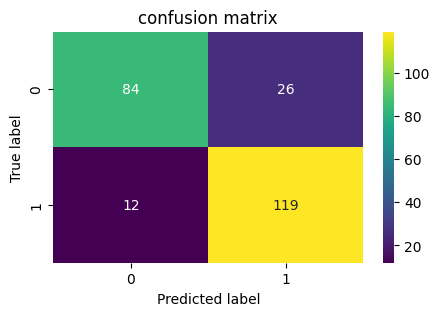

In [50]:
# Get the confusion matrix
conf_mat(y_train, final_model_preds)

+ Because we are predicting diabetes, we need to prioritize recall over precision
+ better to misclassify someone without diabetes to to misclassify someone with diabetes.
+ We are talking about lives here
+ If someone without diabetes was misclassified, further tests will reveal the truth

In [51]:
# Get the prediction probabilities
final_pred_probas = cross_val_predict(final_model, X_train, y_train, cv=5, method="predict_proba")
final_pred_probas[:5]

array([[0.28700261, 0.71299739],
       [0.6629552 , 0.3370448 ],
       [0.82207576, 0.17792424],
       [0.94438592, 0.05561408],
       [0.0763279 , 0.9236721 ]])

In [52]:
# Get the pred probas for "true"
final_pred_probas_1 = final_pred_probas[:, 1]
final_pred_probas_1[:5]

array([0.71299739, 0.3370448 , 0.17792424, 0.05561408, 0.9236721 ])

In [53]:
# Get the precision and recall at all possible thresholds
precisions, recalls, thresholds = precision_recall_curve(y_true=y_train, probas_pred=final_pred_probas_1)

In [54]:
precisions[:15]  # Remember precision starts off low

array([0.54356846, 0.54583333, 0.54811715, 0.55042017, 0.55274262,
       0.55508475, 0.55744681, 0.55982906, 0.56223176, 0.56465517,
       0.56709957, 0.56956522, 0.5720524 , 0.5745614 , 0.57709251])

In [55]:
recalls[:15]  # Recall start of high

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [56]:
thresholds[:15]  # the threshold has been arranged from the lowest to the highest value

array([0.00763775, 0.01146995, 0.01514261, 0.02288012, 0.02316686,
       0.02432469, 0.02744764, 0.02797292, 0.03330604, 0.0360111 ,
       0.03822639, 0.03861739, 0.03904131, 0.04049793, 0.04133717])

NOTE:  
The dataset is relatively balanced. So will will use ROC curve for evaluation. Rather than PR curve

Visualization

In [60]:
# train and get pred probabilities
final_pred_probas = cross_val_predict(final_model, X_train, y_train, cv=5, method="predict_proba")
pred_probas = final_pred_probas[:, 1]

In [61]:
# Create an interactive plot to visualize change in threshold values
def make_cnf_matrix(threshold):
    # Get predictions
    y_pred = pred_probas > threshold
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))

    # Classification report
    print(classification_report(y_train, y_pred))
    print(f"Roc Auc score: {roc_auc_score(y_train, y_pred)}")
    
    # Plot confusion matrix
    ax1 = axes[0]
    conf_mat = confusion_matrix(y_train, y_pred)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis', cbar=False, ax=ax1)
    ax1.set_xlabel('Predicted labels')
    ax1.set_ylabel('True labels')
    ax1.set_title('Confusion Matrix')

    # Plot ROC curve
    ax2 = axes[1]
    
    fpr, tpr, thresholds = roc_curve(y_train, pred_probas)
    ax2.plot(fpr, tpr)
    
    idx = (thresholds <= threshold).argmax()
    ax2.plot([fpr[idx]], [tpr[idx]], "ko", label=f"Point at {threshold} threshold")
    ax2.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], "k:")
    ax2.plot([0.0, fpr[idx]], [tpr[idx], tpr[idx]], "k:")

    ax2.set_xticks(np.arange(0, 1.1, 0.1))
    ax2.set_yticks(np.arange(0, 1.1, 0.1))
    ax2.set_xlabel('False Positive Rate (Fall-Out)')
    ax2.set_ylabel('True Positive Rate (Recall)')
    ax2.legend(loc="lower right")
    ax2.set_title('ROC curve ---- FPR vs TPR')

    plt.tight_layout()
    plt.show()

thresh_widget = widgets.FloatSlider(min=0, max=1, value=0.5, step=0.05)

interact(make_cnf_matrix, threshold=thresh_widget);


interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

Im settling for 0.4 threshold value

In [62]:
# Now fit tthe data
final_model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'cp', 'trestbps',
                                                   'chol', 'restecg', 'thalach',
                                                   'oldpeak', 'slope', 'ca',
                                                   'thal']),
                                                 ('cats',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['sex', 'fbs', 'exang'])])),
                ('logreg',
                 LogisticRegression(C=0.2, l1_ratio=0.6, max_iter=500,
                                    n_jobs=-1, penalty='elasticnet',
                                    random_state=42, solver='saga'))])

In [64]:
### Get the prediction probabilities of the test set
test_pred_probas = final_model.predict_proba(X_test)[:, 1]
test_pred_probas[:5]

array([0.22066802, 0.26904663, 0.02977006, 0.64345544, 0.6772934 ])

In [65]:
# Test predictions considering the threshold value i.e 0.4
test_preds = test_pred_probas > 0.4
test_preds[:5]

array([False, False, False,  True,  True])

              precision    recall  f1-score   support

           0       0.95      0.64      0.77        28
           1       0.76      0.97      0.85        33

    accuracy                           0.82        61
   macro avg       0.85      0.81      0.81        61
weighted avg       0.85      0.82      0.81        61



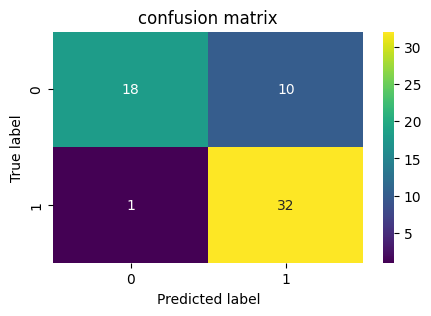

In [66]:
# Classification report
print(classification_report(y_test, test_preds))
conf_mat(y_test, test_preds)

97% recall, the model seems to be performing well. We only misclassified one patient that has diabetes as not having diabetes

In [49]:
# # Pickle the final model

# with open ("final_log_reg_model.pkl", "wb") as f:
#     pickle.dump(final_model, f)

### Communication

In [32]:
final_model.named_steps

{'prep': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('scaler', StandardScaler())]),
                                  ['age', 'cp', 'trestbps', 'chol', 'restecg',
                                   'thalach', 'oldpeak', 'slope', 'ca',
                                   'thal']),
                                 ('cats',
                                  Pipeline(steps=[('onehot',
                                                   OneHotEncoder(sparse_output=False))]),
                                  ['sex', 'fbs', 'exang'])]),
 'logreg': LogisticRegression(C=0.2, l1_ratio=0.6, max_iter=500, n_jobs=-1,
                    penalty='elasticnet', random_state=42, solver='saga')}

In [35]:
# Get the featuers and their importances
features = final_model.named_steps["prep"].get_feature_names_out()
importances = final_model.named_steps['logreg'].coef_[0]
print(importances)

[ 0.          0.75938403 -0.14022855 -0.21111221  0.15898583  0.40224432
 -0.57492549  0.18007085 -0.45075955 -0.47252521  0.35580621 -0.3523334
  0.          0.          0.28568334 -0.28214094]


In [41]:
# Get the minimum and maximum and maximum importances
importances.min(), importances.max()

(-0.574925488945282, 0.7593840262908779)

The coefficients of a logistic regression model are not the coefficient as we see in a linear regression.
Logistic regression is the linear equation wrapped around a sigmoid finction

So we have to take the exponential and get the odds ratio

In [38]:
odds_ratios = pd.Series(np.exp(importances), index=features).sort_values()
odds_ratios.head()

num__oldpeak     0.562747
num__thal        0.623426
num__ca          0.637144
cats__sex_1      0.703046
cats__exang_1    0.754167
dtype: float64

In [39]:
odds_ratios.min(), odds_ratios.max()

(0.5627467981023041, 2.136959504135115)

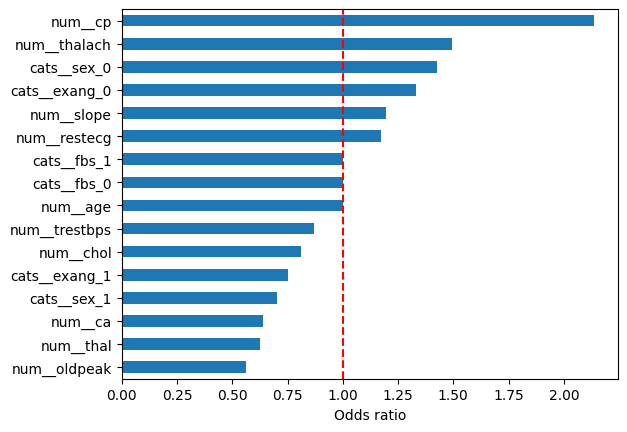

In [49]:
# Horizontal bar chart, five largest coefficients
odds_ratios.tail(17).plot(
    kind='barh', xlabel=("Odds ratio")
)
plt.axvline(x=1, color='red', linestyle='--');

+ cp(chest pain type) is the most predictive of heart diseas
+ The odds of having a heart disease is when you have chest pain is 2 times greater than when you have any other symptom 